# 注意力机制

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## Nadaraya-Watson 核回归

In [3]:
n_train = 50  # 训练样本数
# torch.sort返回排序后的张量和原张量在排序后张量中的对应索引
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数

def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

tensor([1.3536, 0.6822, 0.6609, 1.9777, 1.9631, 2.0219, 2.9065, 2.6908, 3.2244,
        3.4556, 2.6599, 2.2981, 3.5097, 4.4398, 3.7818, 3.2026, 4.3271, 2.9561,
        3.9585, 2.8609, 3.7542, 3.2487, 4.9672, 4.3989, 3.6736, 2.4265, 2.4144,
        3.2912, 2.7818, 3.4319, 2.4208, 2.2499, 1.4758, 2.7711, 2.6286, 1.4430,
        1.9523, 1.7473, 2.3566, 1.7893, 1.6881, 1.9013, 1.9981, 2.4339, 1.9062,
        1.4157, 1.6396, 1.3421, 0.8175, 1.2460])
tensor(2.5309)
tensor([2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309,
        2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309,
        2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309,
        2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309,
        2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309, 2.5309,
        2.5309, 2.5309, 2.5309, 2.5309, 2.5309])


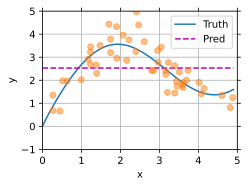

In [4]:
print(y_train)
print(y_train.mean())

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
print(y_hat)
plot_kernel_reg(y_hat)

### 批量矩阵乘法

In [5]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1))
print(values.unsqueeze(-1))
# 权重在第一维升维，值在第二维升维，这里unsqueeze(-1) = unsqueeze(2)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])
tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]])


tensor([[[ 4.5000]],

        [[14.5000]]])

## 带参数的注意力池化

In [6]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [12]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# eye函数为了生成对角线全1，其余部分全0的二维数组。
# keys的形状:('n_train'，'n_train'-1)
print((1 - torch.eye(n_train)).type(torch.bool))
print(X_tile[(1 - torch.eye(n_train)).type(torch.bool)])
print(X_tile[(1 - torch.eye(n_train)).type(torch.bool)].shape)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

print(keys)
print(values)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])
tensor([0.2714, 0.4459, 0.5186,  ..., 4.1468, 4.6053, 4.8176])
torch.Size([2450])
tensor([[0.2714, 0.4459, 0.5186,  ..., 4.6053, 4.8176, 4.8825],
        [0.2656, 0.4459, 0.5186,  ..., 4.6053, 4.8176, 4.8825],
        [0.2656, 0.2714, 0.5186,  ..., 4.6053, 4.8176, 4.8825],
        ...,
        [0.2656, 0.2714, 0.4459,  ..., 4.1468, 4.8176, 4.8825],
        [0.2656, 0.2714, 0.4459,  ..., 4.1468, 4.6053, 4.8825],
        [0.2656, 0.2714, 0.4459,  ..., 4.1468, 4.6053, 4.8176]])
tensor([[0.6822, 0.6609, 1.9777,  ..., 1.3421, 0.8175, 1.2460],
        [1.3536, 0.6609, 1.9777,  ..., 1.3421, 0.8175, 1.2460],
        [1.3536, 0.6822, 1.977

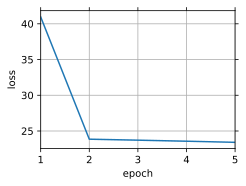

In [8]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

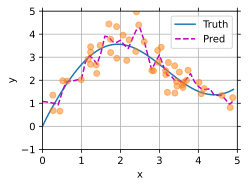

In [9]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

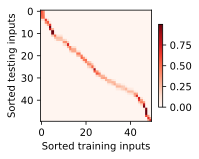

In [10]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 注意力评分函数